In [8]:
import os
import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skorch import NeuralNetClassifier
from skorch.callbacks import Checkpoint, EarlyStopping

import torch.nn as nn
import torch.optim as optim
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic2"):
    os.chdir("..")
    print(f"Changed to {os.getcwd()}")

from codebase import(
    IGNORE_RULES, 
    apply_ignore_rules,
    SktorchNN,
    age_col,
    transport_mode_col,
    categorical_cols,
    load_features_per_num,
    save_features_per_num,
    id_col,
    run_multiclass_classification
    )
from codebase.data_loading.load_odin import load_odin
run_ML = False
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The flag "run_ML" will ensure you don't waste any time training the models and go straight to seeing the plot of how the number of features impacts accuracy

In [9]:
if run_ML:
    odin_df = load_odin(dropna=True)

Now a classifier that classifies what mode of transport was used

In [10]:
if run_ML:
    age_range = (0, np.inf)
    vehicles_to_include = [1, 7, 8, 9, ]
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    df_less_vehicles = odin_df[odin_df[transport_mode_col].isin(vehicles_to_include)]
    df_less_vehicles: pd.DataFrame = df_less_vehicles[(df_less_vehicles[age_col] < age_range[1]) & (df_less_vehicles[age_col] > age_range[0])]

In [11]:
feature_savename = "data/features_per_num.pkl"
accs_savename = "data/accuracies_per_num_nn.pkl"


if run_ML:
    features_per_num, random_forest_accs = load_features_per_num()
    y_translation = {val: order for order, val in enumerate(vehicles_to_include)}

    lr = 0.001
    output_dim=len(vehicles_to_include)
    hidden_layers=[500, 200, 100]
    max_epochs=5
    accs = dict()
    save_path = "neural_net_checkpoints"
    for num, features in features_per_num.items():

        cols_to_include = features.index.to_list()
        # Align the columns with the DataFrame to make a correct count
        cols_to_include = [col for col in cols_to_include if col in df_less_vehicles.columns]

        checkpoint = Checkpoint(monitor='valid_loss_best', f_params=save_path + f'/best_model_{len(cols_to_include)}.pt')
        early_stopping = Checkpoint(monitor='valid_loss_best', f_patience=2, f_params=save_path + f'/best_model_{len(cols_to_include)}.pt')

        net = NeuralNetClassifier(
            SktorchNN(output_dim=output_dim, hidden_layers=hidden_layers),
            max_epochs=max_epochs,
            lr=lr,
            batch_size=32,
            optimizer=optim.Adam,
            criterion=nn.CrossEntropyLoss(),
            verbose=1,
            device=device,
            callbacks=[checkpoint, early_stopping],
        )

        pipeline_less, (X_train_less, X_test, y_test, y_pred), accuracy = run_multiclass_classification(
                df_less_vehicles,
                test_size=0.2,
                model=net,
                drop_cols=[col for col in df_less_vehicles.columns if col not in cols_to_include + [id_col, transport_mode_col]],
                categorical_features=categorical_cols,
                plot=True,
                savename=f"graphics/classification_results/multiclass/neural_net/less_vehicles_{len(cols_to_include)}",
                plot_title=f"Confusion Matrix for Neural Network on NL with {len(cols_to_include)} features",
                y_translation=y_translation,
            )

        print(f"Accuracy of the neural network model with {len(cols_to_include)} features: {accuracy:.4f}")
        accs[len(cols_to_include)] = accuracy
    # Save the accuracies to a file
    save_features_per_num(accuracies=accs, accs_savename=accs_savename)

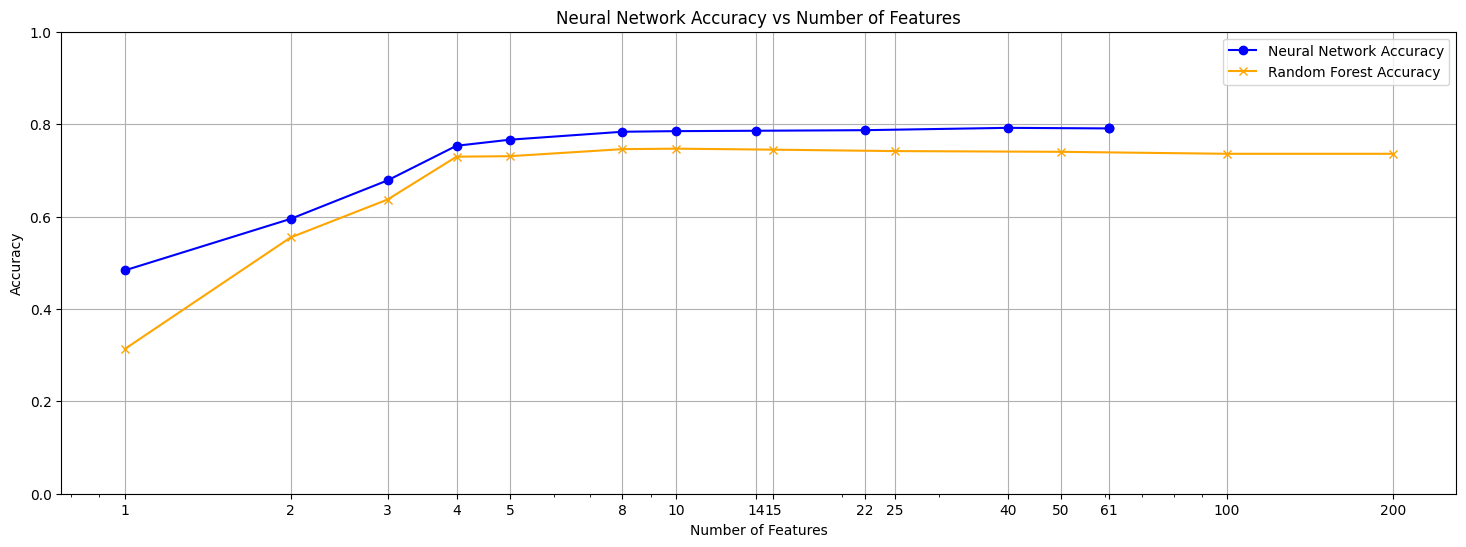

In [12]:
_, random_forest_accs = load_features_per_num()
# Load the accuracies from the file
_, accs = load_features_per_num(accs_savename=accs_savename)
# Did not save these correctly, takes 40 mins to run, so hardcoded for now
x_ticks_nn = [61, 61, 40, 22, 14, 10, 8, 5, 4, 3, 2, 1]
# plot the accuracies
plt.figure(figsize=(18, 6))
plt.plot(x_ticks_nn, list(accs.values()), marker='o', label='Neural Network Accuracy', color='blue')
plt.plot(list(accs.keys()), list(random_forest_accs), marker='x', label='Random Forest Accuracy', color='orange')
plt.title('Neural Network Accuracy vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.grid()
plt.ylim(0, 1)
plt.xscale('log')

all_ticks = sorted(set(list(accs.keys()) + x_ticks_nn))

plt.xticks(all_ticks, [str(x) for x in all_ticks], )
plt.legend()
plt.savefig("graphics/classification_results/multiclass/neural_net/accuracy_vs_num_features.png", bbox_inches='tight', dpi=300)
plt.show()